### Random Forest - Classification

### The Data

We will be using the same dataset through our discussions on classification with tree-methods (Decision Tree,Random Forests, and Gradient Boosted Trees) in order to compare performance metrics across these related models.

We will work with the "Palmer Penguins" dataset, as it is simple enough to help us fully understand how changing hyperparameters can change classification results.


<img src="penguin.jpg" style="max-width:400px">

Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

Summary:
The data folder contains two CSV files. For intro courses/examples, you probably want to use the first one (penguins_size.csv).

* penguins_size.csv: Simplified data from original penguin data sets. Contains variables:

    * species: penguin species (Chinstrap, Adélie, or Gentoo)
    * culmen_length_mm: culmen length (mm)
    * culmen_depth_mm: culmen depth (mm)
    * flipper_length_mm: flipper length (mm)
    * body_mass_g: body mass (g)
    * island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    * sex: penguin sex

* (Not used) penguins_lter.csv: Original combined data for 3 penguin species  

Note: The culmen is "the upper ridge of a bird's beak" 

**Our goal is to create a model that can help predict a species of a penguin based on physical attributes, then we can use that model to help researchers classify penguins in the field, instead of needing an experienced biologist**

## Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

from mpl_toolkits.mplot3d import Axes3D 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.style.use('classic')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("penguins_size.csv")

In [3]:
df = df.dropna()
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181.000,3750.000,MALE
1,Adelie,Torgersen,39.500,17.400,186.000,3800.000,FEMALE
2,Adelie,Torgersen,40.300,18.000,195.000,3250.000,FEMALE
4,Adelie,Torgersen,36.700,19.300,193.000,3450.000,FEMALE
5,Adelie,Torgersen,39.300,20.600,190.000,3650.000,MALE


## Exploratory Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,334.000,43.994,5.461,32.100,39.500,44.500,48.575,59.600
culmen_depth_mm,334.000,17.160,1.968,13.100,15.600,17.300,18.700,21.500
flipper_length_mm,334.000,201.015,14.022,172.000,190.000,197.000,213.000,231.000
body_mass_g,334.000,4209.057,804.836,2700.000,3550.000,4050.000,4793.750,6300.000


In [6]:
for feature in df.columns:
    if df[feature].dtype=="object":
        print(df[feature].unique())

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']
['MALE' 'FEMALE' '.']


In [7]:
df[df["sex"]== "."]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
336,Gentoo,Biscoe,44.500,15.700,217.000,4875.000,.


In [8]:
df[df.species =="Gentoo"].groupby("sex").describe().T

sex                            .   FEMALE     MALE
culmen_length_mm  count    1.000   58.000   61.000
                  mean    44.500   45.564   49.474
                  std        NaN    2.051    2.721
                  min     44.500   40.900   44.400
                  25%     44.500   43.850   48.100
                  50%     44.500   45.500   49.500
                  75%     44.500   46.875   50.500
                  max     44.500   50.500   59.600
culmen_depth_mm   count    1.000   58.000   61.000
                  mean    15.700   14.238   15.718
                  std        NaN    0.540    0.741
                  min     15.700   13.100   14.100
                  25%     15.700   13.800   15.200
                  50%     15.700   14.250   15.700
                  75%     15.700   14.600   16.100
                  max     15.700   15.500   17.300
flipper_length_mm count    1.000   58.000   61.000
                  mean   217.000  212.707  221.541
                  std        NaN    3.898    5.673
                  min    217.000  203.000  208.000
                  25%    217.000  210.000  218.000
                  50%    217.000  212.000  221.000
                  75%    217.000  215.000  225.000
                  max    217.000  222.000  231.000
body_mass_g       count    1.000   58.000   61.000
                  mean  4875.000 4679.741 5484.836
                  std        NaN  281.578  313.159
                  min   4875.000 3950.000 4750.000
                  25%   4875.000 4462.500 5300.000
                  50%   4875.000 4700.000 5500.000
                  75%   4875.000 4875.000 5700.000
                  max   4875.000 5200.000 6300.000

In [9]:
df.loc[336, "sex"] = "MALE"

In [10]:
df["species"].value_counts()

Adelie       146
Gentoo       120
Chinstrap     68
Name: species, dtype: int64

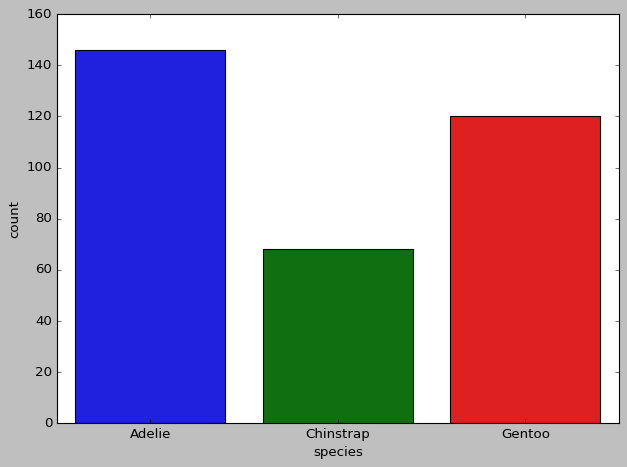

In [11]:
sns.countplot(x="species", data = df)
plt.tight_layout();

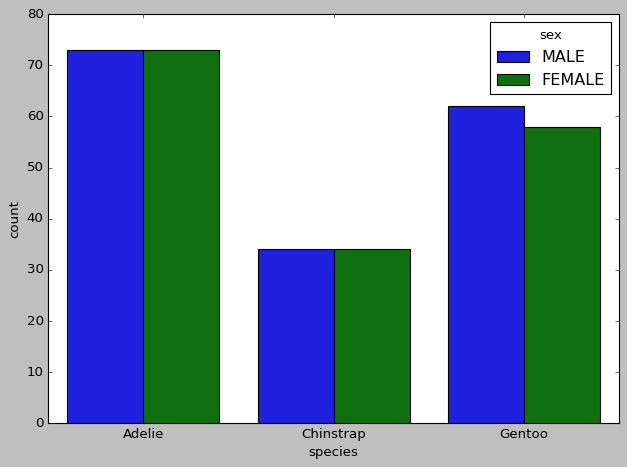

In [12]:
sns.countplot(x="species", data = df, hue = "sex")
plt.tight_layout();

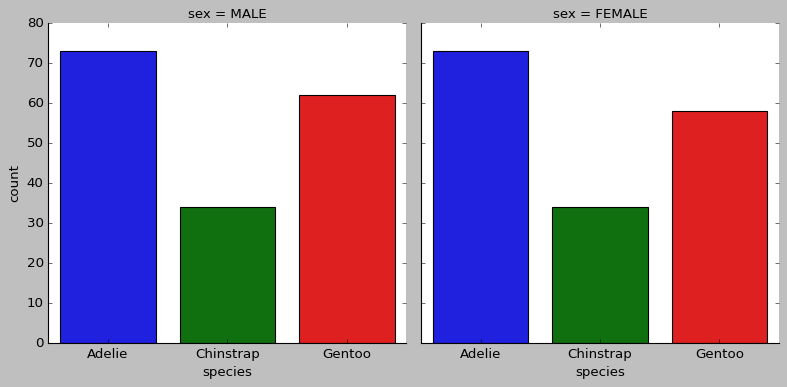

In [13]:
sns.catplot(x='species', data=df, kind='count',col='sex')
plt.tight_layout();

<Figure size 960x480 with 0 Axes>

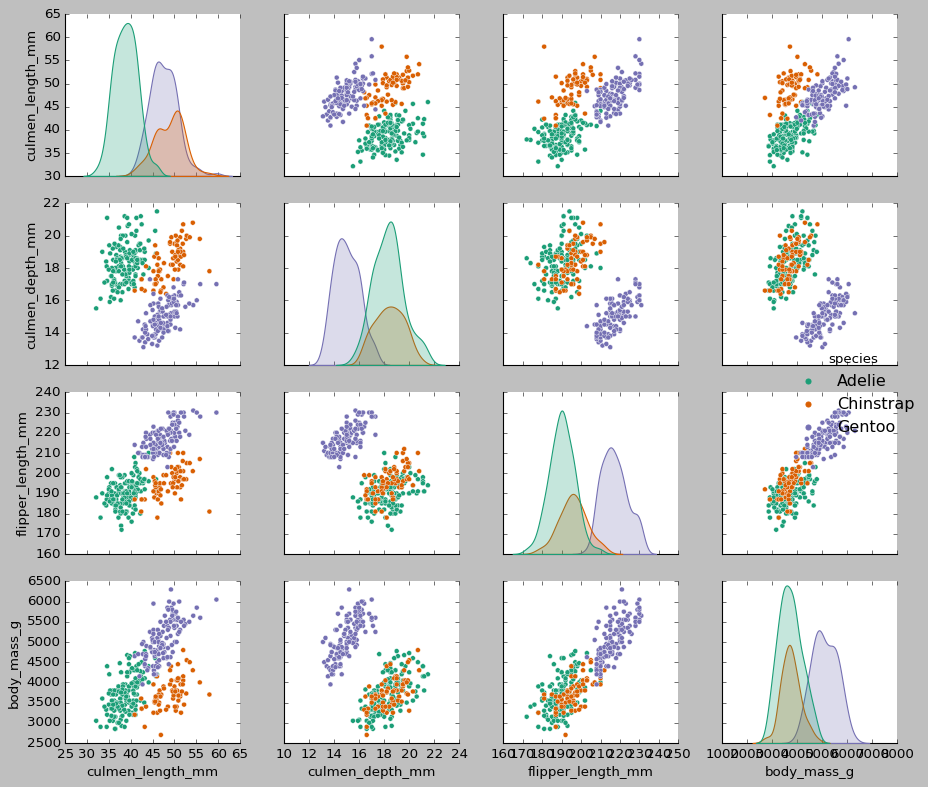

In [14]:
plt.figure(figsize=(12,6))
sns.pairplot(df,hue='species',palette='Dark2')
plt.tight_layout();

In [15]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100,18.700,181.000,3750.000,MALE
1,Adelie,Torgersen,39.500,17.400,186.000,3800.000,FEMALE
2,Adelie,Torgersen,40.300,18.000,195.000,3250.000,FEMALE
4,Adelie,Torgersen,36.700,19.300,193.000,3450.000,FEMALE
5,Adelie,Torgersen,39.300,20.600,190.000,3650.000,MALE


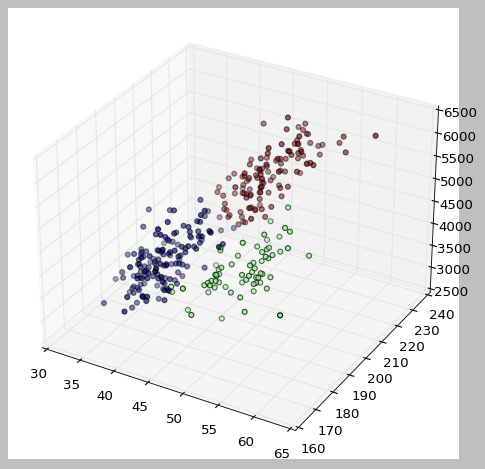

In [16]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = df["species"].map({'Adelie':0, 'Chinstrap':1, 'Gentoo':2})
ax.scatter(df['culmen_length_mm'], df['flipper_length_mm'], df['body_mass_g'], c = colors )
plt.tight_layout();

In [17]:
#import plotly.express as px
#colors = df["species"].map({'Adelie':0, 'Chinstrap':1, 'Gentoo':2})
#fig = px.scatter_3d(df, x='culmen_length_mm', y='flipper_length_mm', z='body_mass_g', color="species")
#fig.show()

## Train | Test Split

In [18]:
X = df.drop('species',axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['species']

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Modelling and Model Performance

In [21]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [23]:
dt_model = DecisionTreeClassifier(random_state=101)

dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[40  1  0]
 [ 2 21  0]
 [ 0  0 37]]
              precision    recall  f1-score   support

      Adelie       0.95      0.98      0.96        41
   Chinstrap       0.95      0.91      0.93        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.97       101
   macro avg       0.97      0.96      0.97       101
weighted avg       0.97      0.97      0.97       101



### DT Model Feature Importance

In [24]:
dt_feature_imp = pd.DataFrame(index = X.columns,
                              data = dt_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
dt_feature_imp

,Feature Importance
flipper_length_mm,0.543
culmen_length_mm,0.326
island_Dream,0.078
culmen_depth_mm,0.053
body_mass_g,0.000
island_Torgersen,0.000
sex_MALE,0.000


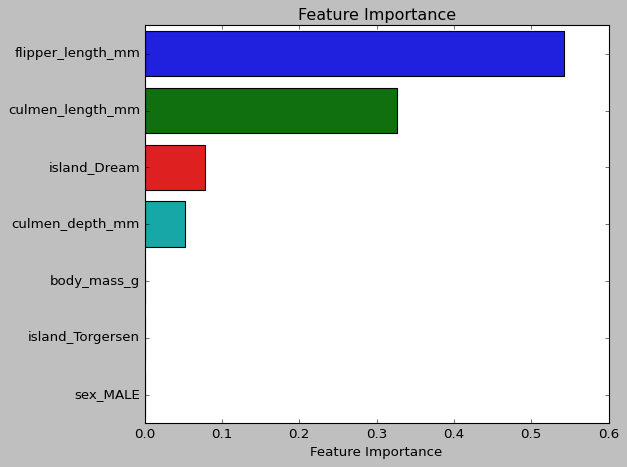

In [25]:
sns.barplot(x=dt_feature_imp["Feature Importance"], y=dt_feature_imp.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [28]:
rf_model = RandomForestClassifier(random_state=101)

rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[40  1  0]
 [ 1 22  0]
 [ 0  0 37]]
              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        41
   Chinstrap       0.96      0.96      0.96        23
      Gentoo       1.00      1.00      1.00        37

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101



### RF Model Feature Importance

In [29]:
rf_feature_imp = pd.DataFrame(index = X.columns,
                              data = rf_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
culmen_length_mm,0.360
flipper_length_mm,0.229
culmen_depth_mm,0.152
body_mass_g,0.123
island_Dream,0.102
island_Torgersen,0.025
sex_MALE,0.008


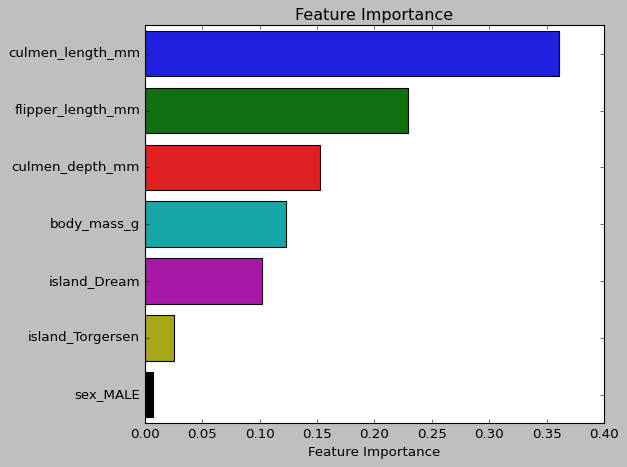

In [30]:
sns.barplot(x=rf_feature_imp["Feature Importance"], y=rf_feature_imp.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

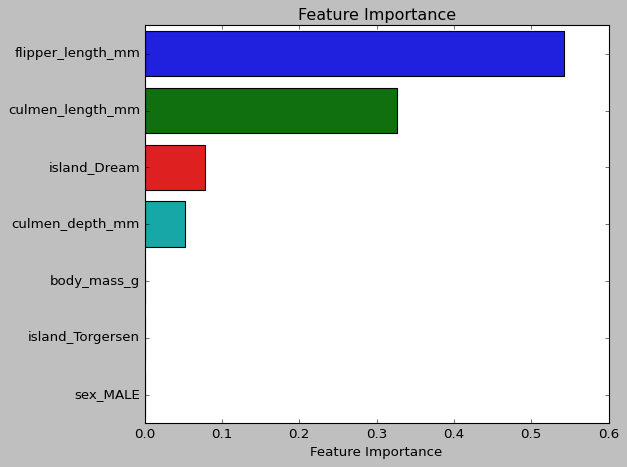

In [31]:
sns.barplot(x=dt_feature_imp["Feature Importance"], y=dt_feature_imp.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

## Choosing correct number of trees

Let's explore if continually adding more trees improves performance...

In [32]:
from sklearn.metrics import accuracy_score

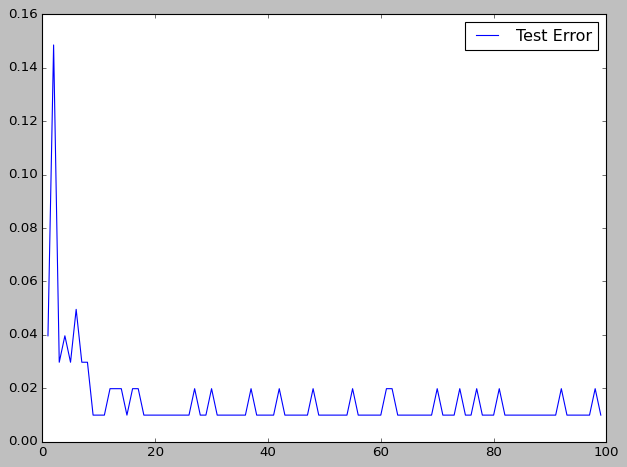

In [33]:
test_error = []

for n in range(1,100):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n, max_features='auto')
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds, y_test))

plt.plot(range(1,100), test_error, label='Test Error')
plt.legend()
plt.tight_layout();

Clearly there are diminishing returns, on such a small dataset, we've pretty much extracted all the information we can after about 15 trees.

## Understanding of HyperParameters with diabetes dataset

In [34]:
df = pd.read_csv("diabetes.csv")

In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## Train | Test Split and Scalling

In [38]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()

In [43]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling and Model Performance

### Decision Tree

In [44]:
dt_model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)

dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
y_train_pred = dt_model.predict(X_train)

dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[92 32]
 [21 47]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       124
           1       0.59      0.69      0.64        68

    accuracy                           0.72       192
   macro avg       0.70      0.72      0.71       192
weighted avg       0.74      0.72      0.73       192



,train_set,test_set
Accuracy,1.000,0.724
Precision,1.000,0.595
Recall,1.000,0.691
f1,1.000,0.639


In [45]:
model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall  test_f1
1      0.009       0.009          0.724           0.583        0.700    0.636
2      0.013       0.010          0.603           0.440        0.550    0.489
3      0.005       0.010          0.672           0.529        0.450    0.486
4      0.006       0.012          0.655           0.500        0.600    0.545
5      0.005       0.009          0.741           0.667        0.500    0.571
6      0.005       0.007          0.759           0.688        0.550    0.611
7      0.009       0.004          0.737           0.647        0.550    0.595
8      0.003       0.012          0.544           0.364        0.400    0.381
9      0.005       0.006          0.649           0.500        0.550    0.524
10     0.004       0.004          0.719           0.611        0.550    0.579
--------------------
test_accuracy    0.680
test_precision   0.553
test_recall      0.540
test_f1          0.542
dtype: float64


In [46]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 9, 15]}

In [47]:
model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)
dt_grid_model = GridSearchCV(estimator=model,
                             param_grid=param_grid,
                             scoring='recall',
                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


In [48]:
dt_grid_model.best_params_

{'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'splitter': 'random'}

In [49]:
y_pred = dt_grid_model.predict(X_test)
y_train_pred = dt_grid_model.predict(X_train)

dt_tuned_acc = accuracy_score(y_test, y_pred)
dt_tuned_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[50 74]
 [10 58]]
              precision    recall  f1-score   support

           0       0.83      0.40      0.54       124
           1       0.44      0.85      0.58        68

    accuracy                           0.56       192
   macro avg       0.64      0.63      0.56       192
weighted avg       0.69      0.56      0.56       192



,train_set,test_set
Accuracy,0.590,0.562
Precision,0.455,0.439
Recall,0.905,0.853
f1,0.605,0.580


In [50]:
dt_model = DecisionTreeClassifier(class_weight = "balanced", random_state=101,
                                  max_depth = 5,
                                  max_features = 3,
                                  min_samples_leaf = 2,
                                  min_samples_split = 9,
                                  splitter = "best").fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
y_train_pred = dt_grid_model.predict(X_train)

dt_tuned_acc = accuracy_score(y_test, y_pred)
dt_tuned_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[82 42]
 [11 57]]
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       124
           1       0.58      0.84      0.68        68

    accuracy                           0.72       192
   macro avg       0.73      0.75      0.72       192
weighted avg       0.77      0.72      0.73       192



,train_set,test_set
Accuracy,0.590,0.724
Precision,0.455,0.576
Recall,0.905,0.838
f1,0.605,0.683


### Random Forest

In [51]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[105  19]
 [ 25  43]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       124
           1       0.69      0.63      0.66        68

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.74       192
weighted avg       0.77      0.77      0.77       192



,train_set,test_set
Accuracy,0.590,0.771
Precision,0.455,0.694
Recall,0.905,0.632
f1,0.605,0.662


In [52]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11))

print(df_scores)

print("--------------------")

print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall  test_f1
1      0.400       0.032          0.724           0.625        0.500    0.556
2      0.297       0.027          0.724           0.577        0.750    0.652
3      0.309       0.027          0.741           0.727        0.400    0.516
4      0.286       0.029          0.724           0.591        0.650    0.619
5      0.218       0.017          0.759           0.667        0.600    0.632
6      0.206       0.022          0.845           0.923        0.600    0.727
7      0.209       0.020          0.807           0.909        0.500    0.645
8      0.211       0.021          0.702           0.571        0.600    0.585
9      0.230       0.021          0.737           0.647        0.550    0.595
10     0.211       0.018          0.772           0.769        0.500    0.606
--------------------
test_accuracy    0.753
test_precision   0.701
test_recall      0.565
test_f1          0.613
dtype: float64


In [53]:
param_grid = {'n_estimators':[50, 100, 300],
              'max_features':[2, 3, 4],
              'max_depth':[3, 5, 7, 9],
              'min_samples_split':[2, 5, 8]}

In [54]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)

rf_grid_model = GridSearchCV(model,
                             param_grid,
                             scoring = "recall",
                             n_jobs = -1,
                             verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [55]:
rf_grid_model.best_params_

{'max_depth': 3, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 50}

In [56]:
y_pred = rf_grid_model.predict(X_test)
y_train_pred = rf_grid_model.predict(X_train)

rf_tuned_acc = accuracy_score(y_test, y_pred)
rf_tuned_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[86 38]
 [16 52]]
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       124
           1       0.58      0.76      0.66        68

    accuracy                           0.72       192
   macro avg       0.71      0.73      0.71       192
weighted avg       0.75      0.72      0.72       192



,train_set,test_set
Accuracy,0.797,0.719
Precision,0.668,0.578
Recall,0.825,0.765
f1,0.738,0.658


In [57]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101,
                                  max_depth = 3,
                                  max_features = 2,
                                  min_samples_split = 2,
                                  n_estimators = 50).fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[86 38]
 [16 52]]
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       124
           1       0.58      0.76      0.66        68

    accuracy                           0.72       192
   macro avg       0.71      0.73      0.71       192
weighted avg       0.75      0.72      0.72       192



,train_set,test_set
Accuracy,0.797,0.719
Precision,0.668,0.578
Recall,0.825,0.765
f1,0.738,0.658


In [58]:
from sklearn.tree import plot_tree

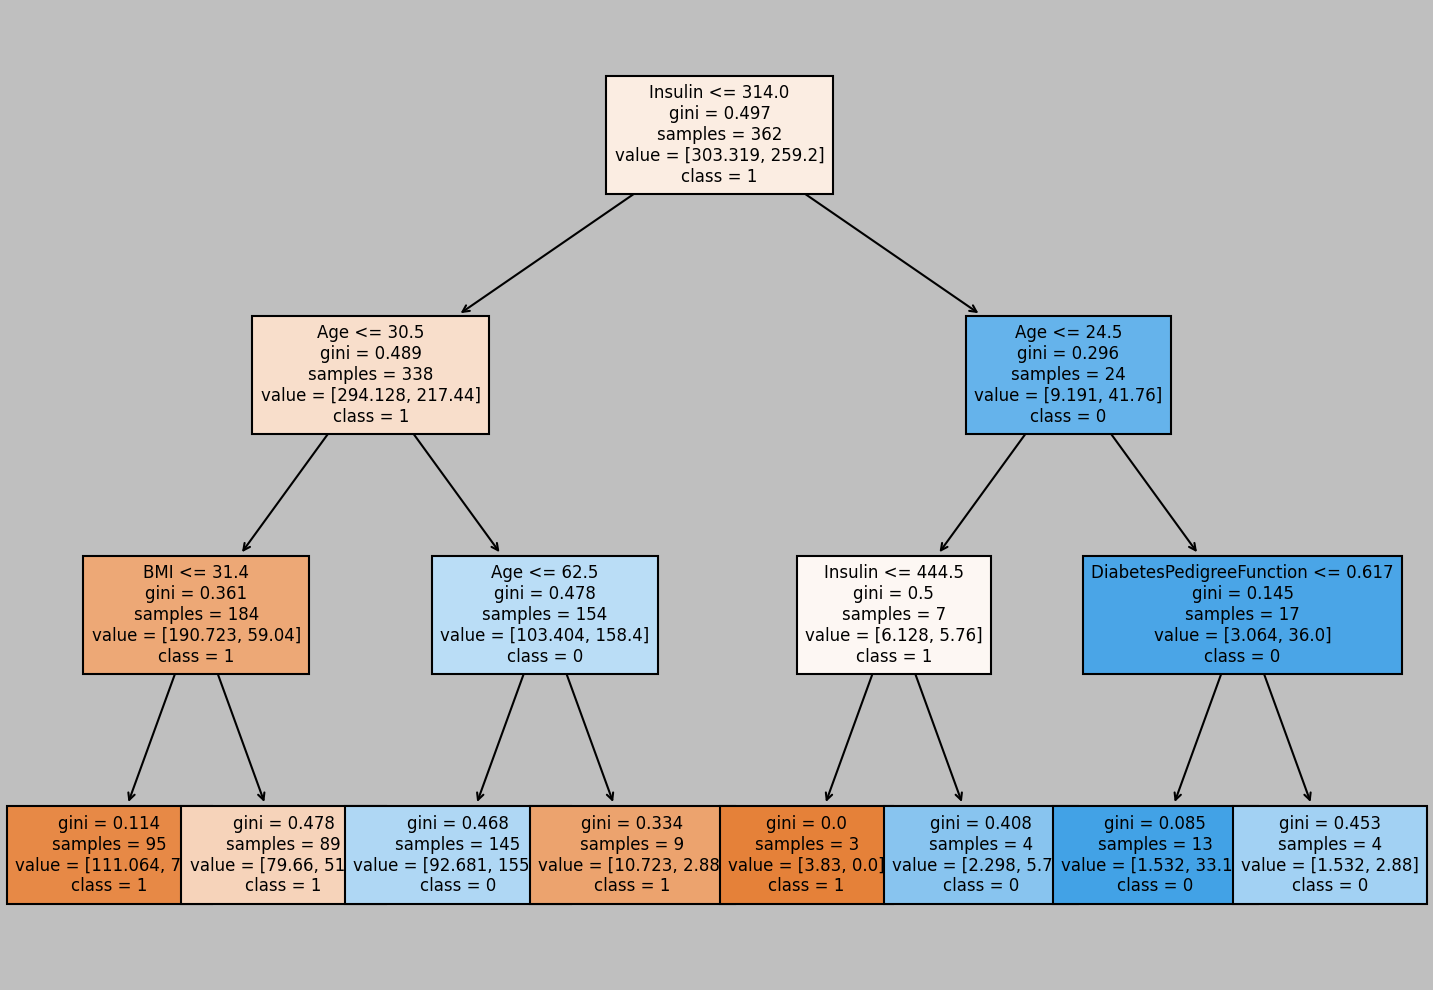

In [59]:
features = list(X.columns)
targets = df.Outcome.astype("str")
targets = targets.unique()

plt.figure(figsize = (12,8), dpi = 150)
plot_tree(rf_model.estimators_[0],
          feature_names = features,
          class_names=targets,
          filled = True,
          fontsize = 8);

### Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
log_model=LogisticRegression(class_weight = "balanced")

log_model.fit(X_train_scaled, y_train)

y_pred=log_model.predict(X_test_scaled)
y_pred_train = log_model.predict(X_train_scaled)

log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[93 31]
 [16 52]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       124
           1       0.63      0.76      0.69        68

    accuracy                           0.76       192
   macro avg       0.74      0.76      0.74       192
weighted avg       0.77      0.76      0.76       192



,train_set,test_set
Accuracy,0.797,0.755
Precision,0.668,0.627
Recall,0.825,0.765
f1,0.738,0.689


In [62]:
model = LogisticRegression(class_weight = "balanced")

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11))

print(df_scores)

print("--------------------")

print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall  test_f1
1      0.173       0.083          0.690           0.538        0.700    0.609
2      0.199       0.011          0.638           0.485        0.800    0.604
3      0.247       0.012          0.759           0.714        0.500    0.588
4      0.580       0.017          0.741           0.600        0.750    0.667
5      0.144       0.020          0.741           0.600        0.750    0.667
6      0.112       0.012          0.793           0.682        0.750    0.714
7      0.118       0.015          0.860           0.750        0.900    0.818
8      0.092       0.029          0.667           0.516        0.800    0.627
9      0.111       0.010          0.772           0.667        0.700    0.683
10     0.087       0.014          0.807           0.765        0.650    0.703
--------------------
test_accuracy    0.747
test_precision   0.632
test_recall      0.730
test_f1          0.668
dtype: float64


### KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train) 
   
    y_pred_test = knn_model.predict(X_test_scaled)
    
    test_error = 1 - recall_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

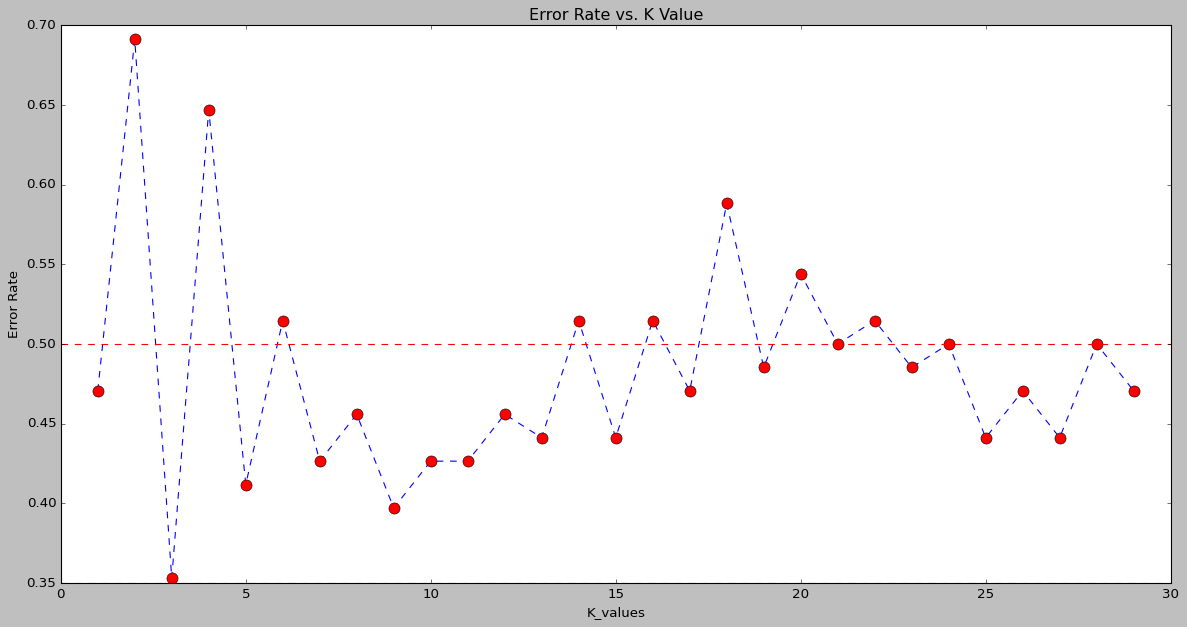

In [65]:
plt.figure(figsize=(15,8))

plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.35, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.5, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

plt.tight_layout();

In [66]:
knn_model = KNeighborsClassifier(n_neighbors = 3)

knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)

knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[104  20]
 [ 24  44]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       124
           1       0.69      0.65      0.67        68

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.75       192
weighted avg       0.77      0.77      0.77       192



,train_set,test_set
Accuracy,0.797,0.771
Precision,0.668,0.688
Recall,0.825,0.647
f1,0.738,0.667


In [67]:
model = KNeighborsClassifier(n_neighbors = 3)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11))

print(df_scores)

print("--------------------")

print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall  test_f1
1      0.002       0.016          0.741           0.632        0.600    0.615
2      0.003       0.014          0.621           0.458        0.550    0.500
3      0.003       0.017          0.793           0.786        0.550    0.647
4      0.026       0.020          0.707           0.600        0.450    0.514
5      0.019       0.044          0.741           0.647        0.550    0.595
6      0.003       0.037          0.707           0.579        0.550    0.564
7      0.003       0.029          0.719           0.625        0.500    0.556
8      0.011       0.027          0.684           0.550        0.550    0.550
9      0.002       0.030          0.632           0.471        0.400    0.432
10     0.002       0.016          0.737           0.632        0.600    0.615
--------------------
test_accuracy    0.708
test_precision   0.598
test_recall      0.530
test_f1          0.559
dtype: float64


### SVM

In [68]:
from sklearn.svm import SVC

In [69]:
svm_model = SVC(class_weight = "balanced")

svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
y_pred_train = svm_model.predict(X_train_scaled)

svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[90 34]
 [14 54]]
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       124
           1       0.61      0.79      0.69        68

    accuracy                           0.75       192
   macro avg       0.74      0.76      0.74       192
weighted avg       0.78      0.75      0.76       192



,train_set,test_set
Accuracy,0.797,0.750
Precision,0.668,0.614
Recall,0.825,0.794
f1,0.738,0.692


In [70]:
model = SVC(class_weight = "balanced")

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11))

print(df_scores)

print("--------------------")

print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall  test_f1
1      0.018       0.013          0.690           0.536        0.750    0.625
2      0.018       0.016          0.655           0.500        0.800    0.615
3      0.024       0.041          0.741           0.667        0.500    0.571
4      0.021       0.054          0.741           0.593        0.800    0.681
5      0.024       0.015          0.793           0.667        0.800    0.727
6      0.022       0.028          0.793           0.654        0.850    0.739
7      0.022       0.013          0.842           0.739        0.850    0.791
8      0.020       0.013          0.702           0.548        0.850    0.667
9      0.022       0.013          0.754           0.636        0.700    0.667
10     0.019       0.013          0.772           0.652        0.750    0.698
--------------------
test_accuracy    0.748
test_precision   0.619
test_recall      0.765
test_f1          0.678
dtype: float64


In [71]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': ["scale", "auto", 1, 0.1, 0.01],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree':[2,3,4]}

In [72]:
model = SVC(class_weight = "balanced")

svm_grid_model = GridSearchCV(model,
                              param_grid,
                              scoring = "f1",
                              n_jobs = -1,
                              verbose = 2).fit(X_train_scaled, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [73]:
svm_grid_model.best_params_

{'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}

In [74]:
y_pred = svm_grid_model.predict(X_test_scaled)
y_pred_train = svm_grid_model.predict(X_train_scaled)

svm_tuned_acc = accuracy_score(y_test, y_pred)
svm_tuned_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[88 36]
 [14 54]]
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       124
           1       0.60      0.79      0.68        68

    accuracy                           0.74       192
   macro avg       0.73      0.75      0.73       192
weighted avg       0.77      0.74      0.75       192



,train_set,test_set
Accuracy,0.797,0.740
Precision,0.668,0.600
Recall,0.825,0.794
f1,0.738,0.684


In [75]:
svm_model = SVC(class_weight = "balanced",
                C = 1,
                gamma = 0.1,
                kernel = "rbf",
                degree = 2).fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
y_pred_train = svm_model.predict(X_train_scaled)

svm_tuned_acc = accuracy_score(y_test, y_pred)
svm_tuned_recall = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train_val(y_train, y_train_pred, y_test, y_pred)

[[88 36]
 [14 54]]
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       124
           1       0.60      0.79      0.68        68

    accuracy                           0.74       192
   macro avg       0.73      0.75      0.73       192
weighted avg       0.77      0.74      0.75       192



,train_set,test_set
Accuracy,0.797,0.740
Precision,0.668,0.600
Recall,0.825,0.794
f1,0.738,0.684


## Model Comparing

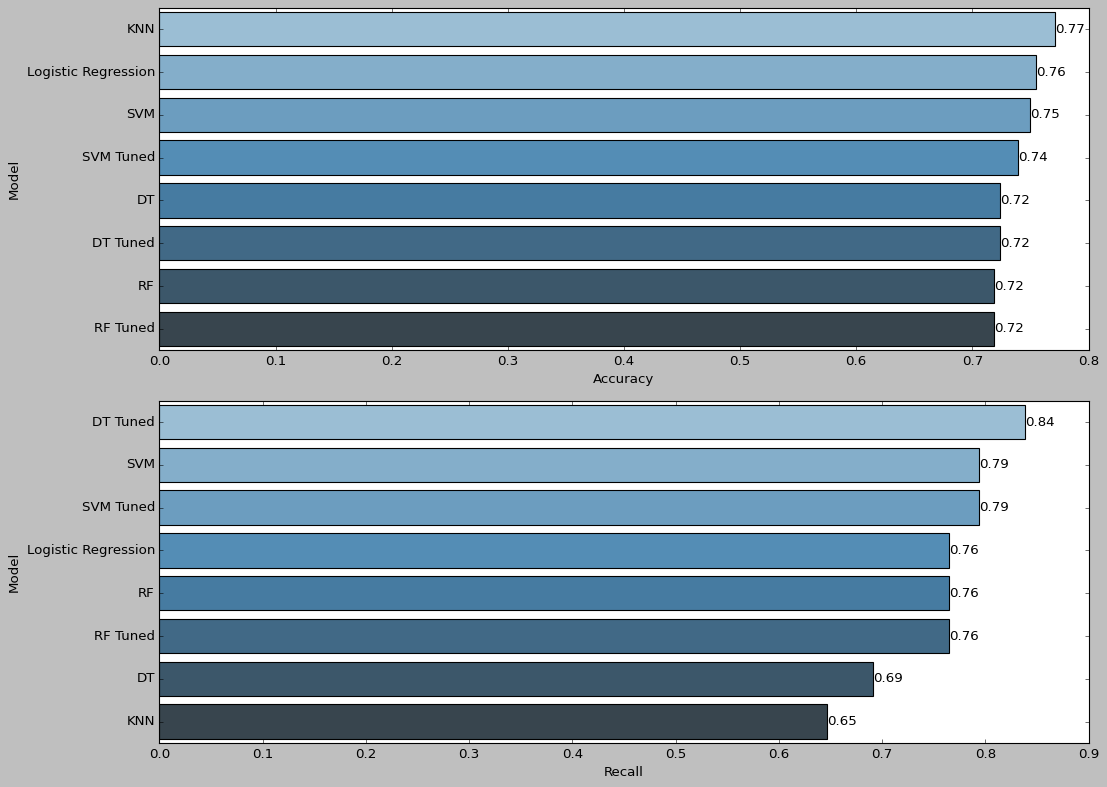

In [76]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "KNN", "SVM", "SVM Tuned", "DT", "DT Tuned", "RF", "RF Tuned"],
                        "Accuracy": [log_acc, knn_acc, svm_acc, svm_tuned_acc, dt_acc, dt_tuned_acc, rf_acc, rf_tuned_acc],
                        "Recall": [log_recall, knn_recall, svm_recall,  svm_tuned_recall, dt_recall, dt_tuned_recall, rf_recall, rf_tuned_recall]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))

plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(212)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.tight_layout()
plt.show()